In [1]:
%load_ext rpy2.ipython

In [35]:
%%R
library(phyloseq)
library(DESeq2)
library(dplyr)
library(magrittr)
library(ggplot2)

In [3]:
%%R
physeq = import_biom("../data/otu_table_tax_no211_meta.biom")
md = sample_data(physeq)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7770 taxa and 119 samples ]
sample_data() Sample Data:       [ 119 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 7770 taxa by 7 taxonomic ranks ]


In [14]:
%%R
physeq.amend = prune_samples(md$Amdmt %in% c("1", "2"), physeq)
physeq.amend

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7770 taxa and 72 samples ]
sample_data() Sample Data:       [ 72 samples by 5 sample variables ]
tax_table()   Taxonomy Table:    [ 7770 taxa by 7 taxonomic ranks ]


In [15]:
%%R
ds = phyloseq_to_deseq2(physeq, ~as.character(Amdmt)*as.numeric(Day))
ds = DESeq(ds)

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 35 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [27]:
%%R
mdf = psmelt(physeq)

In [31]:
%%R
colnames(mdf)

 [1] "OTU"       "Sample"    "Abundance" "Plants"    "DayAmdmt"  "Amdmt"    
 [7] "ID"        "Day"       "Rank1"     "Rank2"     "Rank3"     "Rank4"    
[13] "Rank5"     "Rank6"     "Rank7"    


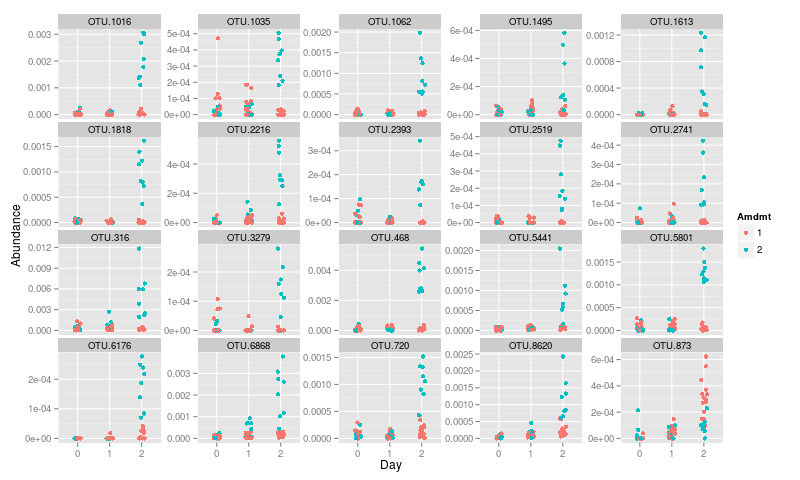

In [51]:
%%R -w 800
FDR = 0.05
N = 20

topN = results(ds) %>% data.frame %>%
    add_rownames("OTU") %>%
    filter(padj <= FDR) %>%
    filter(rank(desc(abs(log2FoldChange)), ties.method = "first") <= N) %>%
    extract2("OTU")

d.plot = mdf %>%
    group_by(Sample) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    filter(OTU %in% topN, Amdmt %in% c("1", "2"))

p = ggplot(d.plot, aes(x = Day, y = Abundance, color = Amdmt))

p = p + facet_wrap(~OTU, scales = "free_y")

p = p + geom_point(position = position_jitter(w = 0.10))

p